In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("C:\\Users\\yrosh\\Documents\\creditcard.csv")

**Exploration**|

In [4]:
df.shape

(284807, 31)

In [5]:
#31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [6]:
df.isnull().values.any()

False

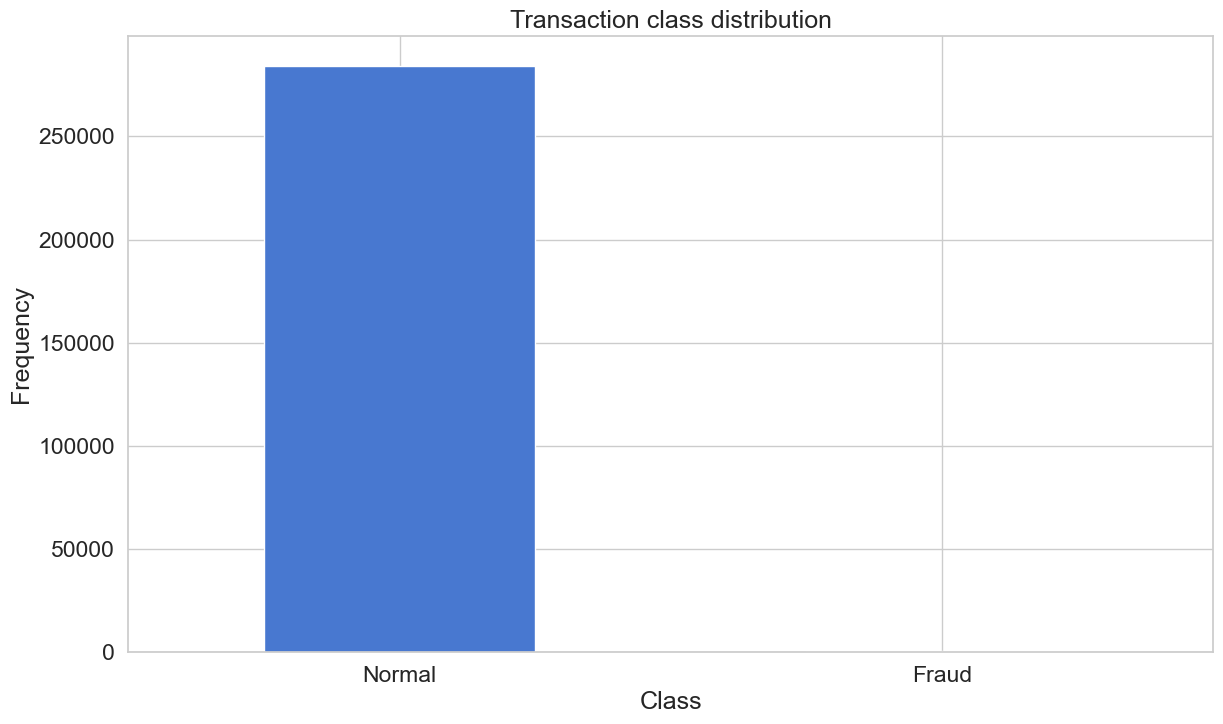

In [7]:
count_classes = df['Class'].value_counts(sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.savefig("transaction_class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
#We have a highly imbalanced dataset. Normal transactions outnumber fraudulent ones by a large margin.
#Let's look at the two types of transactions:

In [9]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [10]:
frauds.shape

(492, 31)

In [11]:
normal.shape

(284315, 31)

In [12]:
#How different are the amount of money used in different transaction classes?

In [13]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [15]:
#Let's have a more graphical representation:

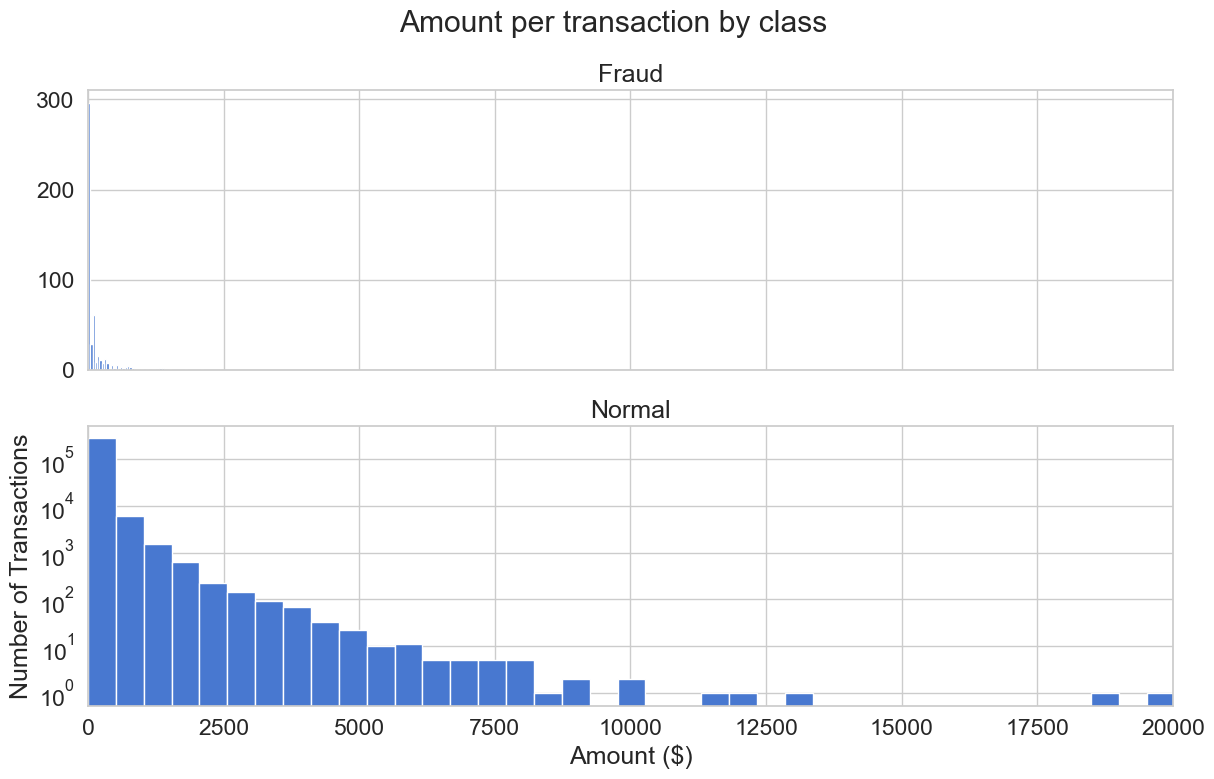

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.savefig('Amount per transaction by class.png', dpi=300, bbox_inches='tight')
plt.show();

In [17]:
#Do fraudulent transactions occur more often during certain time?

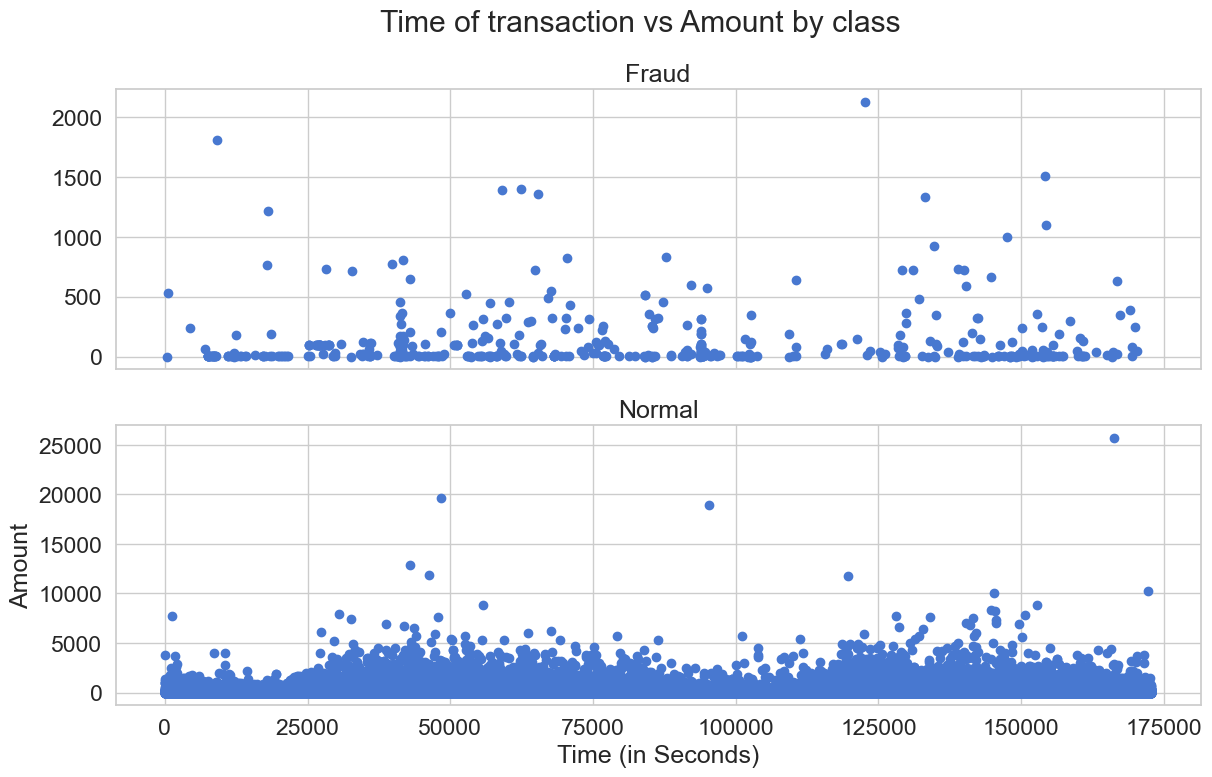

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.savefig('Time of transaction vs Amount by class', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
#Doesn't seem like the time of transaction really matters.

**Autoencoders**

**Preparing the data**

In [20]:
#First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [21]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [22]:
#Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model.
#We will reserve 20% of our data for testing:

In [23]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [24]:
X_train.shape

(227451, 29)

**Building the model**

In [25]:
#Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.
#The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [26]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [27]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [28]:
#Let's train our model for 100 epochs with a batch size of 32 samples and save the best-performing model to a file.
#The ModelCheckpoint provided by Keras is handy for such tasks.
#Additionally, the training progress will be exported in a format that TensorBoard understands.

In [29]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.keras",
                                verbose=0,
                                save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.4649 - loss: 0.8918 - val_accuracy: 0.6424 - val_loss: 0.7904
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6520 - loss: 0.7382 - val_accuracy: 0.6612 - val_loss: 0.7702
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6700 - loss: 0.7259 - val_accuracy: 0.6827 - val_loss: 0.7619
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6803 - loss: 0.7265 - val_accuracy: 0.6917 - val_loss: 0.7576
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6844 - loss: 0.7230 - val_accuracy: 0.6895 - val_loss: 0.7549
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6888 - loss: 0.7166 - val_accuracy: 0.6923 - val_loss: 0.7544
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6913 - loss: 0.6964 - val_accuracy: 0.6927 - val_loss: 0.7512
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6899 - loss: 

In [30]:
autoencoder = load_model('model.keras')

**Evaluation**

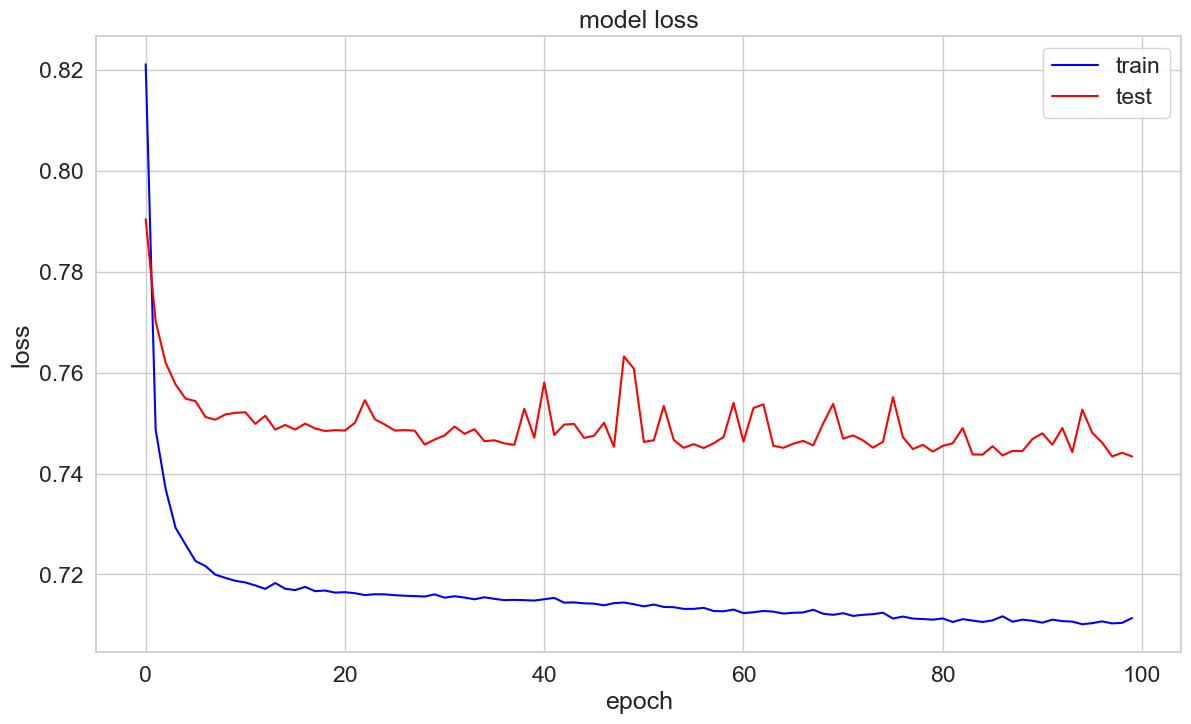

In [61]:
plt.plot(history['loss'], color = 'blue')
plt.plot(history['val_loss'], color = 'red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('model loss')
plt.show();

In [33]:
#The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [34]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step


In [35]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [36]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.735067,0.001720
std,3.495274,0.041443
min,0.047534,0.000000
25%,0.242285,0.000000
50%,0.380160,0.000000
75%,0.608023,0.000000
max,281.717899,1.000000


**Reconstruction error without fraud**

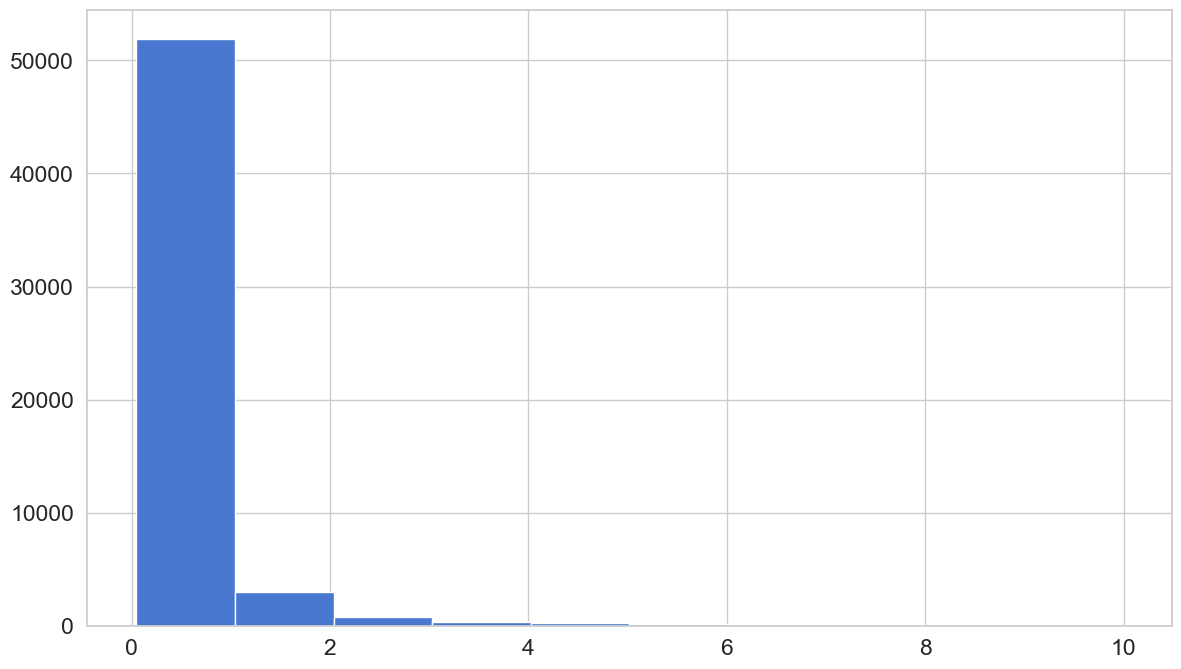

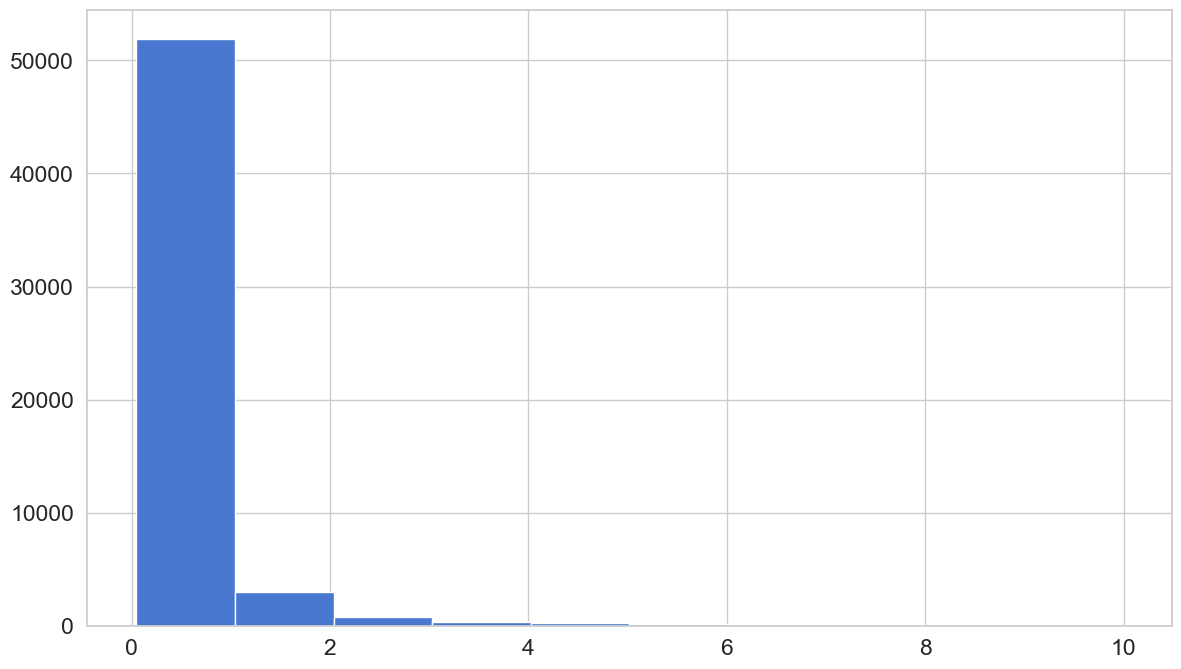

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.show()

**Reconstruction error with fraud**

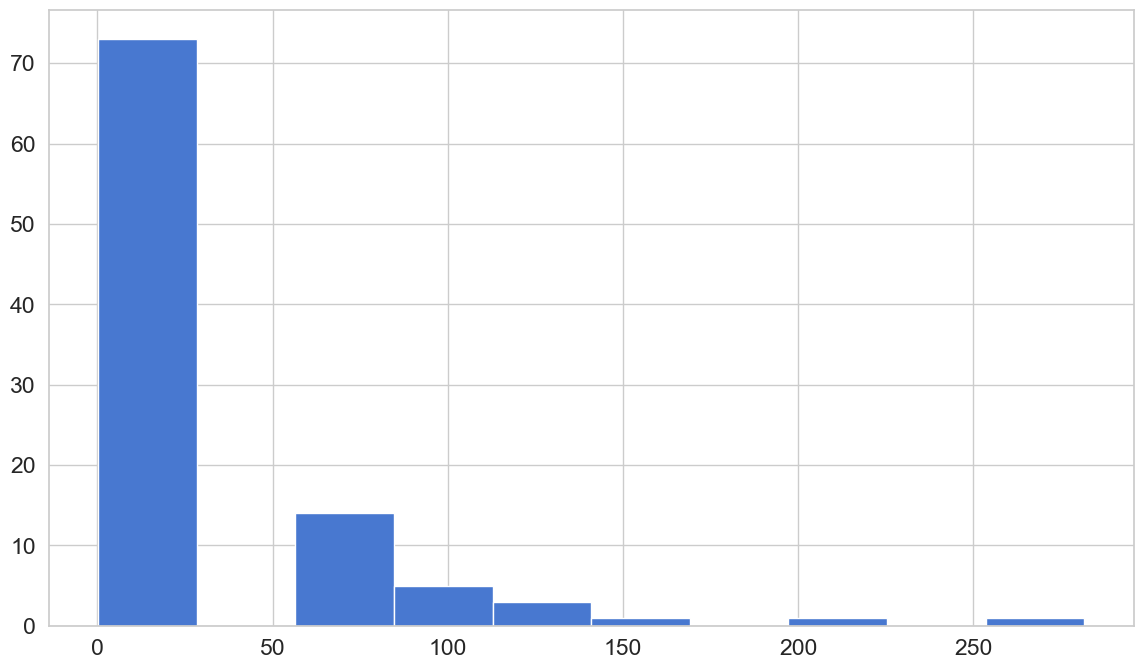

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.show()

In [40]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [41]:
##ROC curves are very useful tool for understanding the performance of binary classifiers.
#However, our case is a bit out of the ordinary. We have a very imbalanced dataset.
#Nonetheless, let's have a look at our ROC curve:

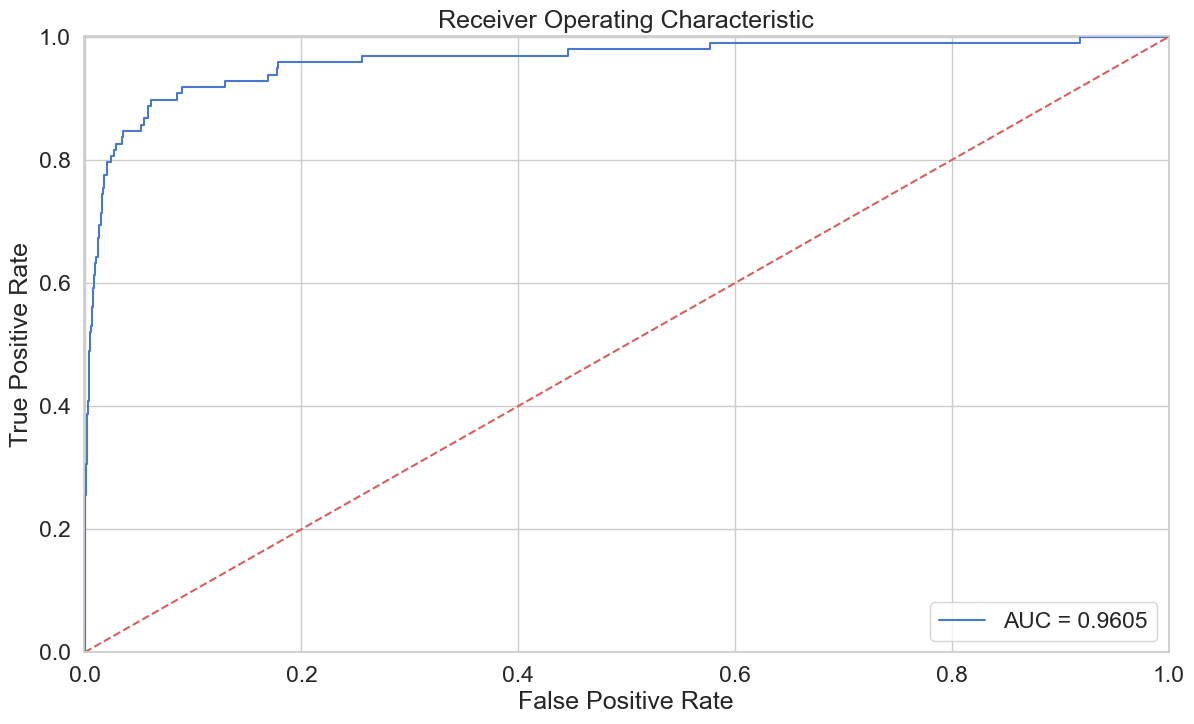

In [62]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Receiver Operating Characteristic')
plt.show();

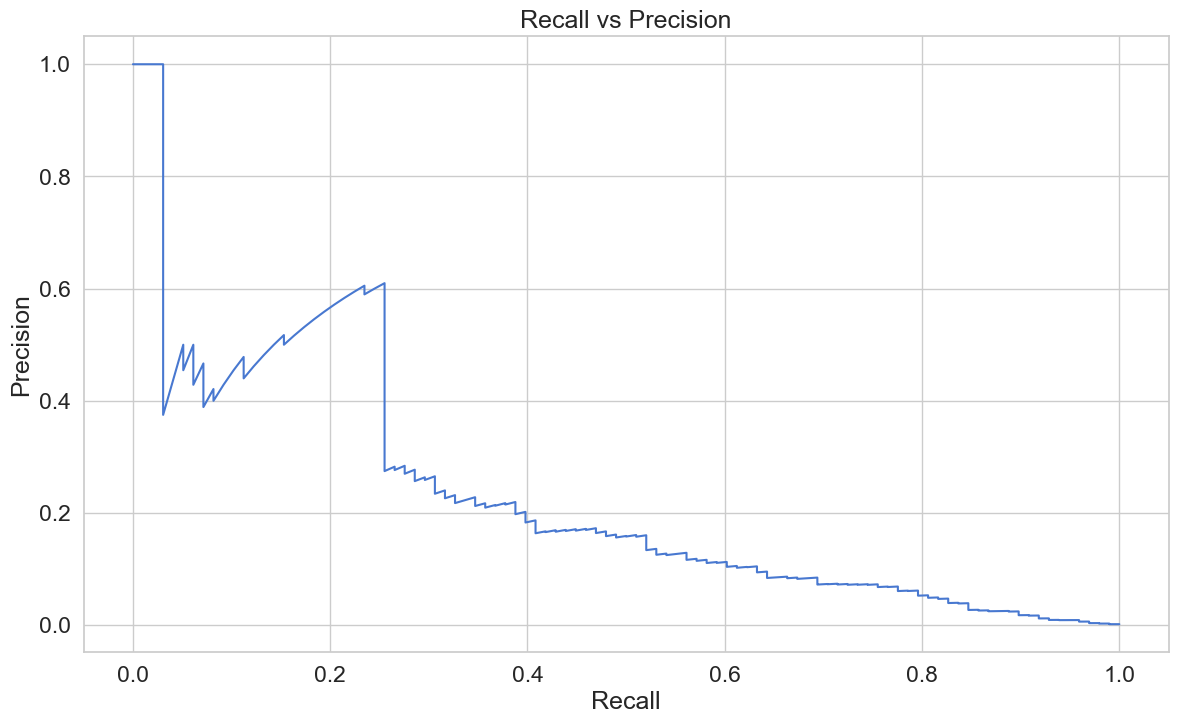

In [63]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('Recall vs Precision')
plt.show()

In [44]:
##A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. 
#High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

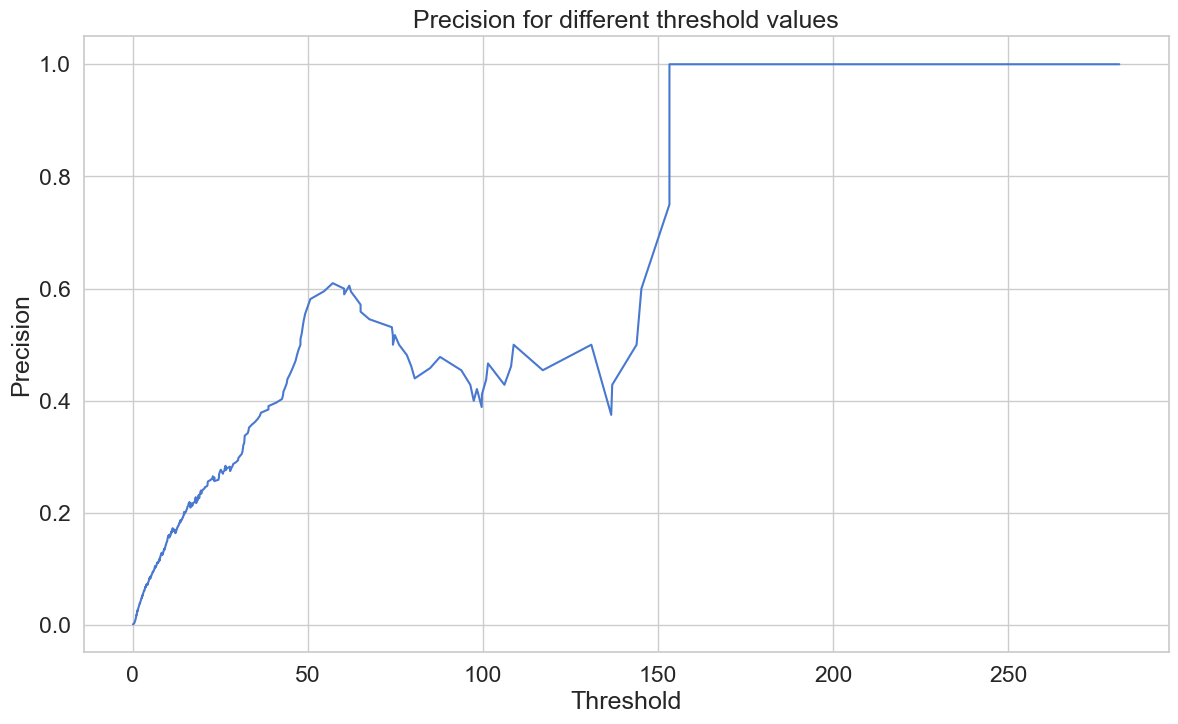

In [64]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.savefig('Precision for different threshold values')
plt.show()

In [46]:
#You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall

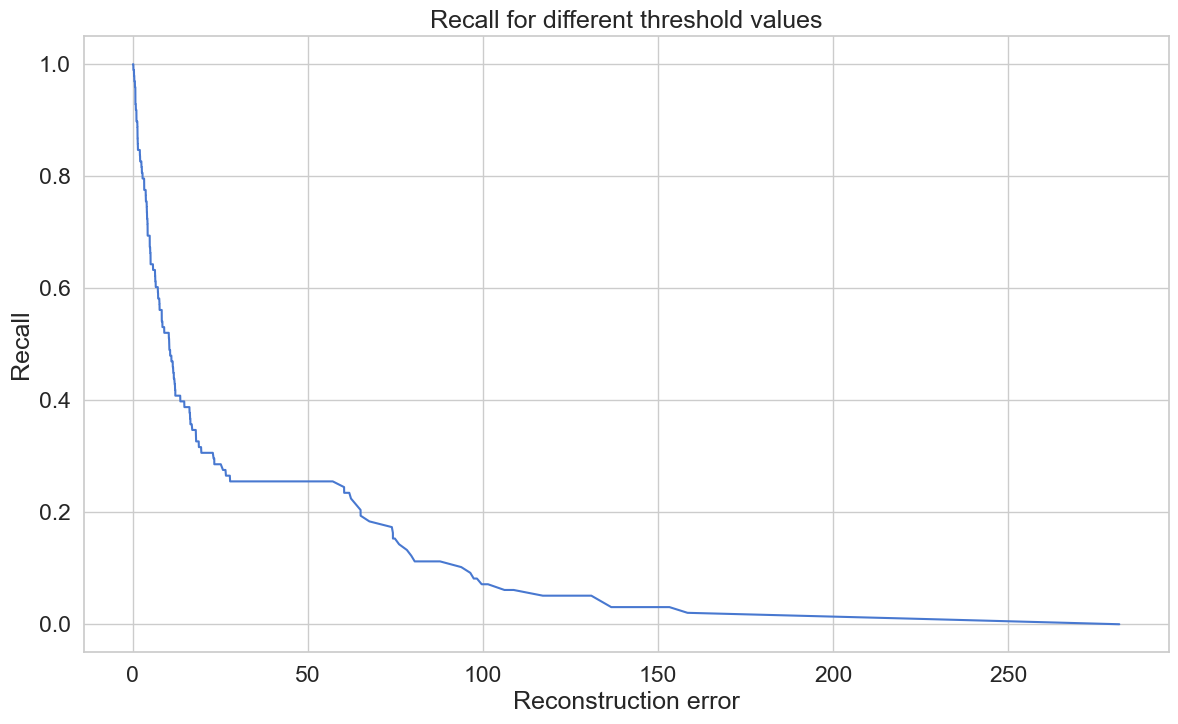

In [65]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.savefig('Recall for different threshold values')
plt.show()

In [48]:
#Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

**Prediction**

In [50]:
#Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. 
# To predict whether a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. 
#If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [51]:
threshold = 2.9

In [52]:
#And see how well we're dividing the two types of transactions:

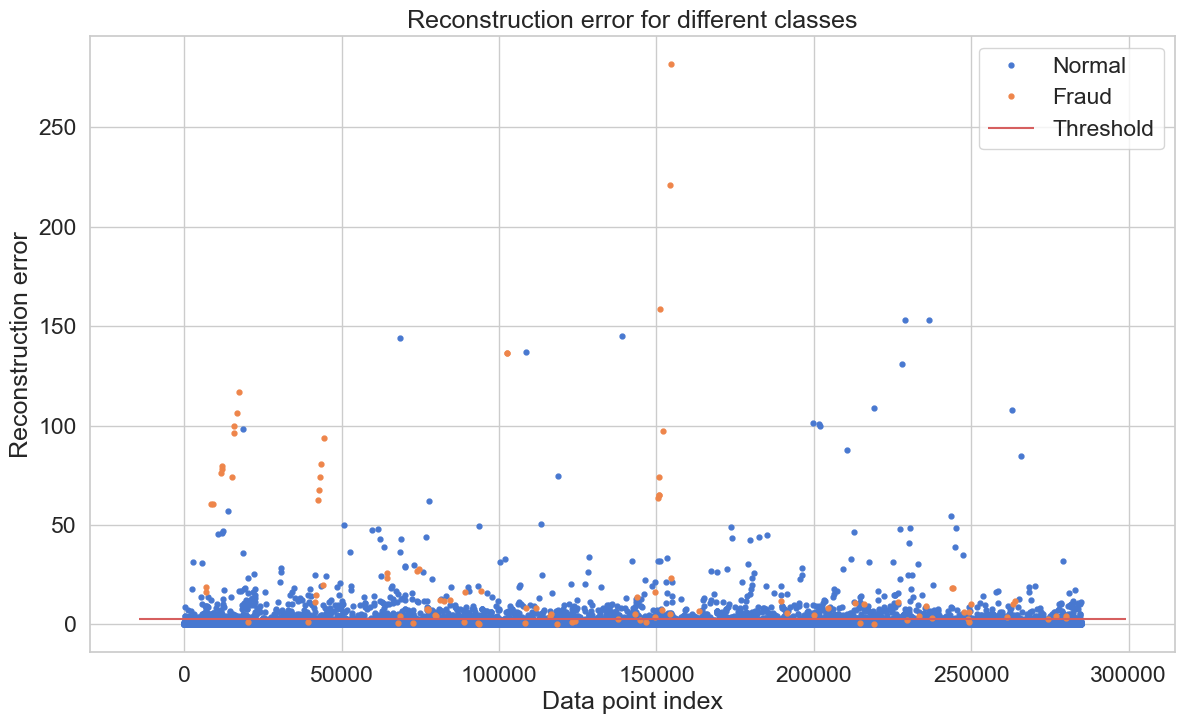

In [66]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.savefig("Reconstruction error for different classes")
plt.show();

In [54]:
#Let's have a look at the confusion matrix:

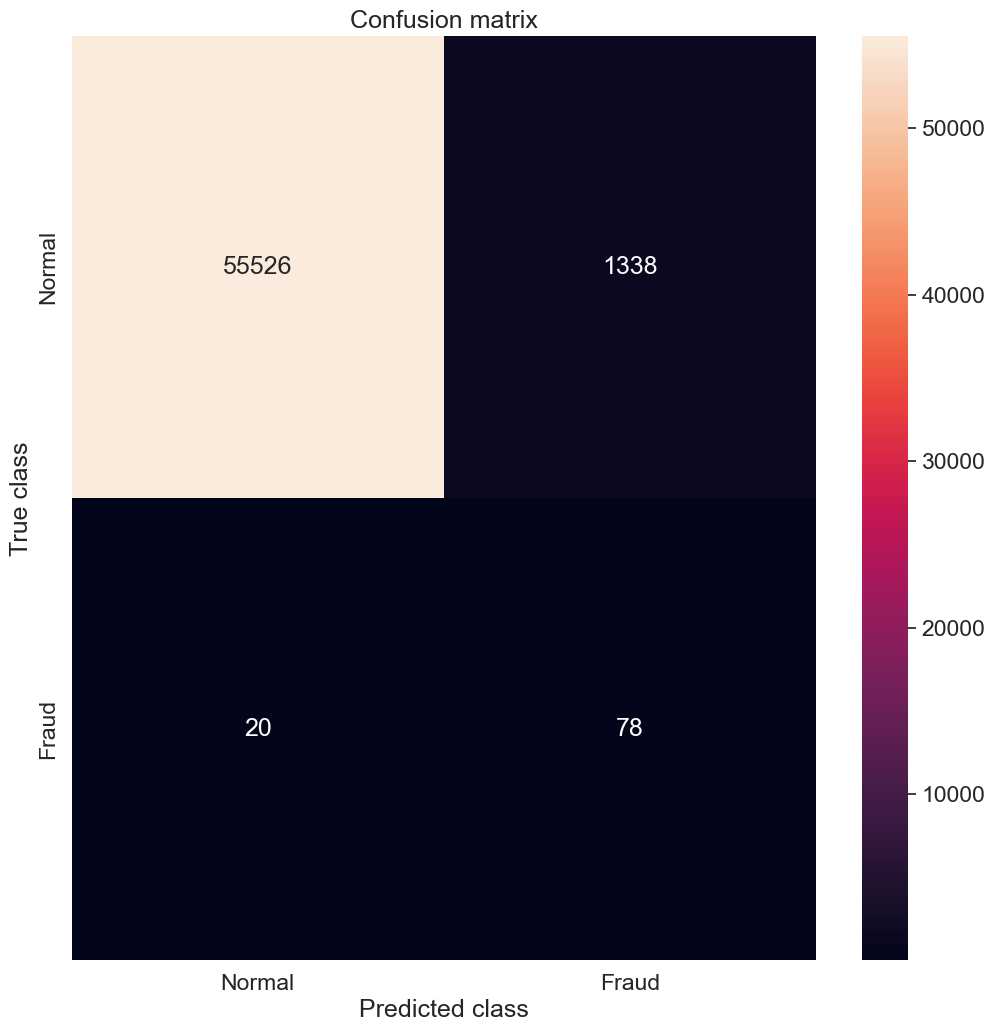

In [67]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig("Confusion matrix")
plt.show()

In [56]:
#Our model seems to catch a lot of the fraudulent cases.
#The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. 
#You might want to increase or decrease the value of the threshold, depending on the problem.

**Conclusion**

In [60]:
#We've created a very simple Deep Autoencoder in Keras that can reconstruct what non-fraudulent transactions look like. 
#Initially, I was a bit skeptical about whether or not this whole thing was gonna work out, but it kinda did. 
#Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) 
#how to discriminate whether or not new examples belong to that same class.